In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import time
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
data_path='./Dataset'

In [ ]:
os.listdir(data_path)

['class_identity.txt',
 'gender.csv',
 'gender_classification.csv',
 'gender_classification.xlsx',
 'Images',
 'list_attribute.txt']

In [ ]:
data = pd.read_csv(data_path+'/gender.csv')
data

,image,Male
0,000051.jpg,1
1,000052.jpg,1
2,000065.jpg,1
3,000166.jpg,1
4,000198.jpg,0
...,...,...
4995,202320.jpg,0
4996,202340.jpg,0
4997,202347.jpg,0
4998,202357.jpg,0


In [ ]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
test_data, val_data = train_test_split(test_data, test_size=0.5, random_state=42)
print("train: {}, test: {}, valid: {}".format(len(train_data), len(test_data), len(val_data)))

train: 4000, test: 500, valid: 500


In [ ]:
class GenderDataset(Dataset):
    def __init__(self, data, image_folder_path, transform=None):
        self.data = data
        self.image_folder_path = image_folder_path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_folder_path, self.data.iloc[idx, 0])
        image = Image.open(image_path)
        image = image.convert('RGB')

        gender = self.data.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(gender, dtype=torch.long)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

transform = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest',
)

transform = transforms.ToTensor()

In [ ]:
batch_size = 32

train_set = GenderDataset(train_data, image_folder_path=os.path.join(data_path, "Images"), transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_set = GenderDataset(test_data, os.path.join(data_path, "Images"), transform=transform)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

val_set = GenderDataset(val_data, os.path.join(data_path, "Images"), transform=transform)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, scheduler=None):
    model = model.to(device)
    train_loss = []
    train_accuracy = []
    val_loss = []
    val_accuracy = []

    for epoch in range(num_epochs):
        start_training = time.perf_counter()
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                model.eval()
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

            model.train()

        end_training = time.perf_counter()
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100.0 * correct / total
        train_loss.append(epoch_loss)
        train_accuracy.append(epoch_accuracy)

        print(f'Epoch [{epoch + 1}/{num_epochs}]\tTraining Loss: {epoch_loss:.4f}\tTraining Accuracy: {epoch_accuracy:.2f}%\t Time: {end_training-start_training:.2f}s')

        start_valid = time.perf_counter()
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                val_Loss = criterion(val_outputs, val_labels)

                val_running_loss += val_Loss.item()
                _, val_predicted = val_outputs.max(1)
                val_total += val_labels.size(0)
                val_correct += val_predicted.eq(val_labels).sum().item()

        end_valid = time.perf_counter()
        val_epoch_loss = val_running_loss / len(val_loader)
        val_epoch_accuracy = 100.0 * val_correct / val_total
        val_loss.append(val_epoch_loss)
        val_accuracy.append(val_epoch_accuracy)

        print(f'Epoch [{epoch + 1}/{num_epochs}]\tValidation Loss: {val_epoch_loss:.4f}\tValidation Accuracy: {val_epoch_accuracy:.2f}%\t Time: {end_valid-start_valid:.2f}s')

        if scheduler != None:
            scheduler.step()
            print("Scheduler active")

    return train_loss, train_accuracy, val_loss, val_accuracy

In [ ]:
def plotting(train_loss, val_loss, train_accuracy, val_accuracy):
  plt.figure(figsize=(12, 6))

  plt.subplot(1, 2, 1)
  plt.plot(train_loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(train_accuracy, label='Training Accuracy')
  plt.plot(val_accuracy, label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [ ]:
def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    predicted_labels = []
    true_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    test_loss /= len(test_loader)
    test_accuracy = 100.0 * correct / total

    precision = precision_score(true_labels, predicted_labels) * 100
    recall = recall_score(true_labels, predicted_labels) * 100
    f1 = f1_score(true_labels, predicted_labels) * 100

    print(f'Accuracy:\t{test_accuracy:.2f}%')
    print(f'Precision:\t{precision:.2f}%')
    print(f'Recall:\t\t{recall:.2f}%')
    print(f'F1-Score:\t{f1:.2f}%')
    print(f'Loss:\t\t{test_loss:.4f}')

    return true_labels, predicted_labels

In [ ]:
def report(true_labels, predicted_labels):
  conf_matrix = confusion_matrix(true_labels, predicted_labels)
  class_report = classification_report(true_labels, predicted_labels)

  print("\nClassification Report:")
  print(class_report)

  print("Confusion Matrix:")
  print(conf_matrix)

  # plotting cofusion matrix
  plt.figure(figsize=(9,6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
              xticklabels=['Female', 'Male'],
              yticklabels=['Female', 'Male'])
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()

In [ ]:
# Architecture
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(4096, 2)

optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Batch Size: 32

In [ ]:
num_epochs = 10
train_loss, train_accuracy, val_loss, val_accuracy = train(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

Epoch [1/10]	Training Loss: 0.2503	Training Accuracy: 89.00%	 Time: 44.01s
Epoch [1/10]	Validation Loss: 0.3029	Validation Accuracy: 87.60%	 Time: 2.65s
Epoch [2/10]	Training Loss: 0.0975	Training Accuracy: 96.20%	 Time: 49.07s
Epoch [2/10]	Validation Loss: 0.0758	Validation Accuracy: 97.60%	 Time: 2.61s
Epoch [3/10]	Training Loss: 0.0474	Training Accuracy: 98.25%	 Time: 49.71s
Epoch [3/10]	Validation Loss: 0.0854	Validation Accuracy: 98.00%	 Time: 2.60s
Epoch [4/10]	Training Loss: 0.0432	Training Accuracy: 98.55%	 Time: 49.00s
Epoch [4/10]	Validation Loss: 0.1131	Validation Accuracy: 97.00%	 Time: 2.60s
Epoch [5/10]	Training Loss: 0.0124	Training Accuracy: 99.62%	 Time: 49.28s
Epoch [5/10]	Validation Loss: 0.0894	Validation Accuracy: 98.20%	 Time: 2.64s
Epoch [6/10]	Training Loss: 0.0132	Training Accuracy: 99.45%	 Time: 49.38s
Epoch [6/10]	Validation Loss: 0.2108	Validation Accuracy: 94.00%	 Time: 2.59s
Epoch [7/10]	Training Loss: 0.0407	Training Accuracy: 98.45%	 Time: 49.60s
Epoch [

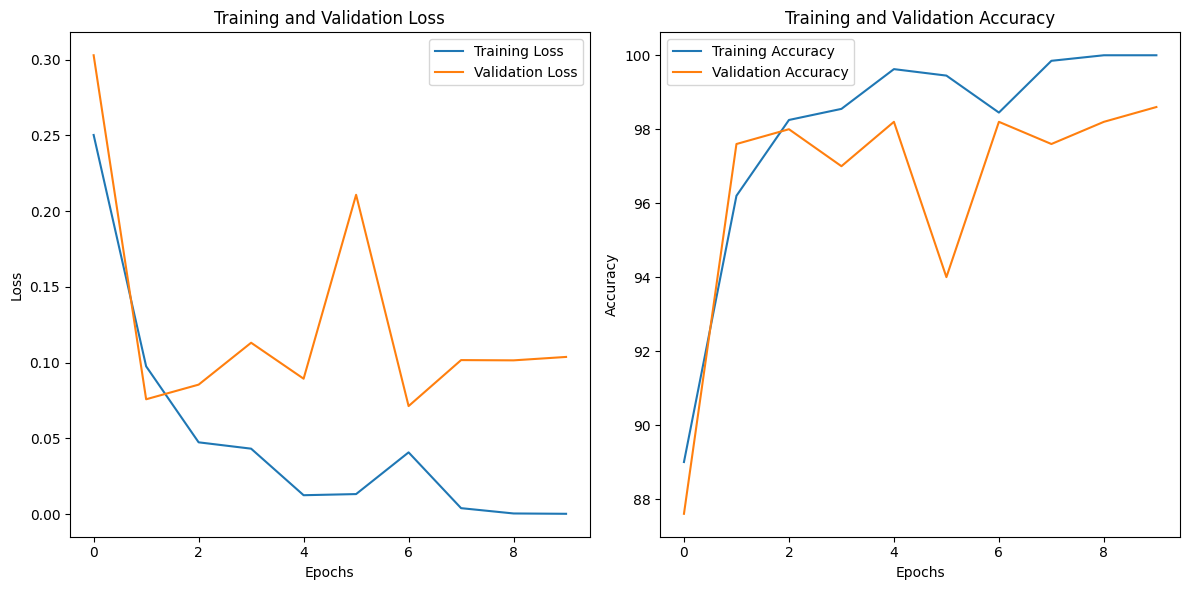

In [ ]:
plotting(train_loss, val_loss, train_accuracy, val_accuracy)

In [ ]:
true_labels, predicted_labels = evaluate(model, test_loader, criterion)

Accuracy:	98.00%
Precision:	97.01%
Recall:		97.99%
F1-Score:	97.50%
Loss:		0.1305


In [ ]:
report(true_labels, predicted_labels)

Confusion Matrix:
[[295   6]
 [  4 195]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       301
           1       0.97      0.98      0.97       199

    accuracy                           0.98       500
   macro avg       0.98      0.98      0.98       500
weighted avg       0.98      0.98      0.98       500



In [ ]:
# Save the model fixed
model_path = './SaveModel/FixModel.pth'
torch.save(model.state_dict(), model_path)

In [ ]:
# Architecture
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(4096, 2)

# load model
model.load_state_dict(torch.load('./SaveModel/FixModel.pth'))
model = model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [ ]:
true_labels, predicted_labels = evaluate(model, test_loader, criterion)

Accuracy:	98.00%
Precision:	97.01%
Recall:		97.99%
F1-Score:	97.50%
Loss:		0.1305



Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       301
           1       0.97      0.98      0.97       199

    accuracy                           0.98       500
   macro avg       0.98      0.98      0.98       500
weighted avg       0.98      0.98      0.98       500

Confusion Matrix:
[[295   6]
 [  4 195]]


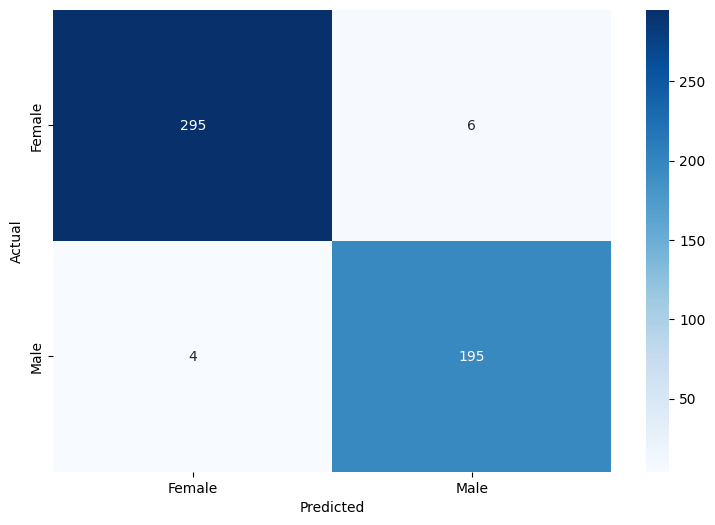

In [ ]:
report(true_labels, predicted_labels)